In [1]:
import pandas as pd
import numpy as np

In [2]:
reviews = pd.read_csv('reviews_merged.csv')

# Collaborative Filtering

This section focuses on collaborative filtering using the Python Surprise package on the ratings data.  Our research on this topic spans three primary types of algorithms: similarity, clustering, and matrix factorization.  Similarity algorithms such as cosine similarity are appealing for their simplicity, ease of use, and swift deployment.  Clustering algorithms, specifically k-Nearest Neighbors (KNN), evolve beyond similarity methods in that they are machine learning models that are fit to training data.  While KNN is a widely known algorithm for recommender system applications, handling large amounts of data can slow it down substantially.  Additionally, in the case of the Amazon Grocery data set, the data was imbalanced, a known hinderance to KNN performance, as it consisted primarily of 5-star reviews.  

A much more interesting, albeit complex solution to building a recommender system, is incorporating matrix factorization techniques.  Three matrix factorization algorithms were researched and tested: Singular Value Decomposition (SVD), SVD++, and Non-Negative Matrix Factorization (NMF).  The appeal of SVD was inspired by the winner of the Netflix Kaggle competition, so we spent a fair amount of time learning the inner workings.  

![alt text](whiteboard.jpg)

Depicted above is the iteration process for minimizing the error of the imputed data after factorizing the primary User/Item matrix.  SVD++ became even more intriguing, due to the fact that it can account for implicit information, that is, baises of users who may only review items they liked or disliked.  Because our data was so skewed to 5-star ratings, we believed this to be a perfect solution, and reasonably so.  What we did not account for at first, was the fact that SVD does not perform especially well on sparse datasets, and in fact, the winner of the Netflix challenge incorporated a neural net algorithm as a method for data imputation.  We then turned to the NMF algorithm.  While NMF is not designed to handle implicit information as ingeniously as SVD++, it does perform well on sparse matrices.  Additionally, it also makes more logical sense when considering the design of the factor matrices.  For example, a user cannot have a negative value as part of the factor composition; if a model assigned a value of -.47 to "User A" as part of "Factor 3", the implication is that "User A" has a negative preference for a type of item.  A user can have anywhere from zero to an extreme affinity for an item - but always exhibiting a lower bound of zero.  Because of this realization, and the fact that our primary User/Item matrix is ~0.1% complete, we concluded that the Non-Negative Matrix Factorization algorithm was the appropriate choice.

# Sources

Amazon Product Data  
Julian McAuley, UCSD  
http://jmcauley.ucsd.edu/data/amazon/  

Matrix Factorization Techniques for Recommender Systems  
https://towardsdatascience.com/paper-summary-matrix-factorization-techniques-for-recommender-systems-82d1a7ace74
  
How Does the Funk Singular Value Decomposition Algorithm work in Recommendation Engines?  
https://medium.com/datadriveninvestor/how-funk-singular-value-decomposition-algorithm-work-in-recommendation-engines-36f2fbf62cac  

Netflix Prize and SVD  
http://buzzard.ups.edu/courses/2014spring/420projects/math420-UPS-spring-2014-gower-netflix-SVD.pdf  

Learning from Incomplete Ratings Using Non-negative Matrix Factorization  
https://archive.siam.org/meetings/sdm06/proceedings/059zhangs2.pdf
  
Non-negative matrix factorization for recommendation systems  
https://medium.com/logicai/non-negative-matrix-factorization-for-recommendation-systems-985ca8d5c16c  

Python Surprise Library  
http://surpriselib.com/

---

In [1]:
import pandas as pd
import numpy as np
import os
os.chdir("C:\\Users\\jonhu\\OneDrive\\School\\Data Mining\\Course Project")
from IPython.display import Image

In [ ]:
import json
import gzip
import os
import pickle
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import surprise
from surprise import AlgoBase
from surprise import Dataset
from surprise import Reader
from surprise.evaluate import GridSearch
from surprise.model_selection.validation import cross_validate
from surprise.similarities import cosine as cos_sim
from surprise.prediction_algorithms.baseline_only import BaselineOnly
from surprise.prediction_algorithms.algo_base import AlgoBase
from surprise import PredictionImpossible
from surprise import similarities
from surprise.prediction_algorithms.matrix_factorization import SVD
from surprise.prediction_algorithms.matrix_factorization import SVDpp
from surprise.prediction_algorithms.matrix_factorization import NMF
from surprise.prediction_algorithms.slope_one import SlopeOne
from surprise import KNNBasic
from surprise.model_selection import KFold
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise.model_selection import RandomizedSearchCV as randomsearch

import gzip
import numpy.ma as ma
PREVIOUS_MAX_ROWS = pd.options.display.max_rows
pd.options.display.max_rows = 20
from pandas import DataFrame 
import nltk

from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from scipy.spatial.distance import cosine
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import mean_squared_error

# Load main libraries
import os
import re
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt

# Import the main libraries to use
import numpy as np
import pandas as pd
import os
import warnings
warnings.simplefilter("ignore")

# Import libraries specific to this analysis

import nltk
from rake_nltk import Rake
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

import turicreate

In [2]:
merged_dataset = pd.read_csv('reviews_merged.csv')
df = merged_dataset.copy()

In [ ]:
meta = pd.read_csv('meta_filtered.csv')
merged = merged_dataset.copy()
df = merged_dataset.copy()

# Subset data for Suprise
df_subset = df[['reviewerID','asin','overall']]


## List unique reviewer IDs
users = list(df_subset['reviewerID'].unique())


## List unique product IDs
all_asin = df_subset['asin'].unique()


######  TIME INTENSIVE  ######
## Create 'asins_from_user' dictionary
asins_from_user = {user:list(df_subset.loc[df_subset['reviewerID']==user, 'asin']) for user in users}

## Create names_from_asin dictionary
name_from_asin = dict(zip(merged['asin'], merged['title']))

## <p style="text-align:center"><span style="color:maroon">Apriori Association Rule Analysis of Amazon Grocery Market Basket</span></p>
---

### Association Rule Mining

To augment the development of our recommendation engines, we believed it would also be meaningful to examine the data from the perspective of association rule mining. Association rules have been applied effectively by marketing groups to increase product sales. They are derived purely from historical transaction information.

The fundamental difference between association rule mining (ARM) and recommender systems is that ARM predicts the likelihood of purchasing an item given its association with either another purchased item, or its association with a more abstract concept (for example, "people who like the color blue are more likely to purchase product X"), without regard to any underlying context. Recommender systems, on the other hand, attempt to create a context for their recommendations based on the properties of the items, the users, or a combination of both.

**Advantages of ARM:**
- ARM rules are straightforward and easy to implement. If a rule is extracted suggesting with high confidence that lift for item *B* is significant when item *A* is purchased, the seller (Amazon in this case) can increase sales of B by creating a "package deal" or bundle with the two items sold together.
- ARM-based strategies are proven. They are in use since the mid-1990s and are relied upon in many applications beyond marketing and sales.
- ARM does not suffer from the "cold start problem" that plagues recommendation systems. They are based purely on historical transactional information.

**Drawbacks of ARM:**
- ARM can be computationally expensive. Algorithms iterate over combinations of items so the size of the rules increases exponentially. For tens of thousands of items and millions of transactions, ARM can become intractable.
- The lack of context or meaning for the rules can be troublesome. For example, what if we have a new item and want to predict whether to combine it with other items? With standard ARM approaches we would be unable to make predictions until there is sufficient transaction data. Unlike recommender systems, ARM tends to remove the user from the picture.

**ARM with Recommender Systems:** There has been considerable research into using ARM-based recommmender systems, especially in the 2000's. There is also research suggesting that ARM can be used in combination with recommender systems as a means to overcome the cold-start problem. In the context of this project, we consider ARM as a method to increase confidence in our recommendations. For example, if ARM shows high confidence and lift for item B given A, do our recommender systems recommend item B to purchasers of A?

**Libraries used:** For ARM analysis we utilized the `mlxtend` and `apyori` Python libraries to extract the rules. Both applications require the dataframe to be preprocessed and reshaped into a form that allows extraction of lists for rule extraction. For our data, this results in a very wide sparse matrix where every user is cast as a transaction (row) and columns represent items in the transaction.

---

## MLXTEND

The first analysis is run on the Amazon grocery dataset using the `apriori` library of the *mlxtend* package. The mlxtend application requires more upfront preprocessing than apyori but provides more extensive output in a much more usable format than apyori.

Import libraries for our analysis:

In [29]:
# Typical Libraries
import numpy as np
import pandas as pd

In [30]:
# Specific to apriori
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [31]:
df = pd.read_csv('reviews_merged.csv')

In [32]:
df.shape

(151254, 17)

In [5]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,salesRank,imUrl,categories,title,description,price,related,brand
0,A1VEELTKS8NLZB,616719923X,Amazon Customer,"[0, 0]",Just another flavor of Kit Kat but the taste i...,4.0,Good Taste,1370044800,"06 1, 2013",{'Grocery & Gourmet Food': 37305},http://ecx.images-amazon.com/images/I/51LdEao6...,[['Grocery & Gourmet Food']],Japanese Kit Kat Maccha Green Tea Flavor (5 Ba...,Green Tea Flavor Kit Kat have quickly become t...,NaN,"{'also_bought': ['B00FD63L5W', 'B0047YG5UY', '...",NaN
1,A14R9XMZVJ6INB,616719923X,amf0001,"[0, 1]",I bought this on impulse and it comes from Jap...,3.0,"3.5 stars, sadly not as wonderful as I had hoped",1400457600,"05 19, 2014",{'Grocery & Gourmet Food': 37305},http://ecx.images-amazon.com/images/I/51LdEao6...,[['Grocery & Gourmet Food']],Japanese Kit Kat Maccha Green Tea Flavor (5 Ba...,Green Tea Flavor Kit Kat have quickly become t...,NaN,"{'also_bought': ['B00FD63L5W', 'B0047YG5UY', '...",NaN
2,A27IQHDZFQFNGG,616719923X,Caitlin,"[3, 4]",Really good. Great gift for any fan of green t...,4.0,Yum!,1381190400,"10 8, 2013",{'Grocery & Gourmet Food': 37305},http://ecx.images-amazon.com/images/I/51LdEao6...,[['Grocery & Gourmet Food']],Japanese Kit Kat Maccha Green Tea Flavor (5 Ba...,Green Tea Flavor Kit Kat have quickly become t...,NaN,"{'also_bought': ['B00FD63L5W', 'B0047YG5UY', '...",NaN
3,A31QY5TASILE89,616719923X,DebraDownSth,"[0, 0]","I had never had it before, was curious to see ...",5.0,Unexpected flavor meld,1369008000,"05 20, 2013",{'Grocery & Gourmet Food': 37305},http://ecx.images-amazon.com/images/I/51LdEao6...,[['Grocery & Gourmet Food']],Japanese Kit Kat Maccha Green Tea Flavor (5 Ba...,Green Tea Flavor Kit Kat have quickly become t...,NaN,"{'also_bought': ['B00FD63L5W', 'B0047YG5UY', '...",NaN
4,A2LWK003FFMCI5,616719923X,Diana X.,"[1, 2]",I've been looking forward to trying these afte...,4.0,"Not a very strong tea flavor, but still yummy ...",1369526400,"05 26, 2013",{'Grocery & Gourmet Food': 37305},http://ecx.images-amazon.com/images/I/51LdEao6...,[['Grocery & Gourmet Food']],Japanese Kit Kat Maccha Green Tea Flavor (5 Ba...,Green Tea Flavor Kit Kat have quickly become t...,NaN,"{'also_bought': ['B00FD63L5W', 'B0047YG5UY', '...",NaN


In [33]:
df.isna().sum()

reviewerID            0
asin                  0
reviewerName       1493
helpful               0
reviewText           22
overall               0
summary               0
unixReviewTime        0
reviewTime            0
salesRank          6962
imUrl               189
categories            0
title               189
description       30518
price             24520
related            5422
brand             47099
dtype: int64

In [34]:
user01 = df.at[0, 'reviewerID']; user01

'A1VEELTKS8NLZB'

In [35]:
invoice01 = df[['reviewerID', 'asin', 'title']].loc[df['reviewerID']==user01, :]; invoice01

,reviewerID,asin,title
0,A1VEELTKS8NLZB,616719923X,Japanese Kit Kat Maccha Green Tea Flavor (5 Ba...
4753,A1VEELTKS8NLZB,B0009K77O8,Yamamotoyama - Genmai Cha (Brown Rice Tea) 90 ...
16342,A1VEELTKS8NLZB,B000F4DKC6,"Twinings Herbal Tea, Lemon &amp; Chinese Ginge..."
31520,A1VEELTKS8NLZB,B000R71WMQ,Raw Organic Apple Cider Vinegar by Bragg (1 ga...
76195,A1VEELTKS8NLZB,B002VT3GXG,"Nongshim Hoo Roo Rook, 3.24 Ounce Bags (Pack o..."
95550,A1VEELTKS8NLZB,B004BJYPCK,Myojo Chukazanmai Instant Ramen Miso Soybean P...
115384,A1VEELTKS8NLZB,B005HUVJYO,"Miyasaka Instant Authentic Soup, Miso, 0.27-Ou..."


In [36]:
invoice_pv = (invoice01.groupby(['reviewerID', 'title'])['asin']
              .count().unstack().reset_index().set_index('reviewerID'))
invoice_pv

title,Japanese Kit Kat Maccha Green Tea Flavor (5 Bag) (4.91oz x 5),"Miyasaka Instant Authentic Soup, Miso, 0.27-Ounce (Pack of 12)","Myojo Chukazanmai Instant Ramen Miso Soybean Paste Flavor, 3.84-Ounce (Pack of 6)","Nongshim Hoo Roo Rook, 3.24 Ounce Bags (Pack of 24)",Raw Organic Apple Cider Vinegar by Bragg (1 gallon),"Twinings Herbal Tea, Lemon &amp; Chinese Ginger, 20 Teabag Box (Pack of 6)",Yamamotoyama - Genmai Cha (Brown Rice Tea) 90 Bag Value Pack
reviewerID,,,,,,,
A1VEELTKS8NLZB,1,1,1,1,1,1,1


**Now convert the whole df the same way:**

In [37]:
df_2 = df[['reviewerID', 'asin', 'title']].copy(deep=True)
basket = (df_2.groupby(['reviewerID', 'title'])['asin'].count().unstack()
          .reset_index().fillna(0).set_index('reviewerID'))

In [38]:
basket.head(8)

title,&quot;Raspberry Leaf C/S Organic 1 pound,1 Gallon 100% Organic Extra Virgin Raw Coconut Oil,1 Gallon Snappy Butter Burst Oil,100 Blooms of Peruvian Lilies,"100 Calorie Packs Lorna Doone Shortbread Cookie Crisps, 6-Count Boxes (Pack of 6)","100 Calorie Packs Oreo Thin Crisps, 6-Count Packs (Pack of 2)","100 Calorie Packs Planters Peanut Butter Cookie Crisps, 6-Count Packs (Pack of 6)",100 Pcs Fortune Cookies Fresh Single Wrap(golden Bowl),100% Bovine GELATIN 14oz.,100% Coconut Milk - 33.8 oz packages (1-pack),...,"mix 1 Protein &amp; Antioxidant Drink, Mix Berry, 11-Ounce Bottles (Pack of 12)","reGen Chocolate Muscle Recovery Beverage, 11-Ounce Containers (Pack of 24)","saf-instant Gold Instant Yeast, 1 Pound Package","thinkOrganic Bar, Chocolate Coconut, 1.4-Ounce Bars (Pack of 15)","thinkThin BITES 100 Calorie Cookies &amp; Cream, Gluten Free, 5-Count (0.88-Ounce) Bars (Pack of 6)","thinkThin Chocolate Covered Strawberries, Gluten Free, 1.76-Ounce Bar (Pack of 10)","thinkThin Chocolate Espresso, Gluten Free, 2.1-Ounce Bars (Pack of 10)","thinkThin Chocolate Fudge, Gluten Free, 2.1-Ounce Bars (Pack of 10)","thinkThin Tangerine Cremesicle, Gluten Free, 1.76-Ounce Bars","truRoots Organic Quinoa 100% Whole Grain Premium Quality, 4 lbs"
reviewerID,,,,,,,,,,,,,,,,,,,,,
A00177463W0XWB16A9O05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A022899328A0QROR32DCT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A04309042SDSL8YX2HRR7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A068255029AHTHDXZURNU,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A06944662TFWOKKV4GJKX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1004703RC79J9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1006HCQDMYC5W,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1008DPSP6KC9J,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Check first that the information is correct using our single test case from above.

In [39]:
basket.loc[user01, :].head()

title
&quot;Raspberry Leaf C/S Organic 1 pound                                             0.0
1 Gallon 100% Organic Extra Virgin Raw Coconut Oil                                   0.0
1 Gallon Snappy Butter Burst Oil                                                     0.0
100 Blooms of Peruvian Lilies                                                        0.0
100 Calorie Packs Lorna Doone Shortbread Cookie Crisps, 6-Count Boxes (Pack of 6)    0.0
Name: A1VEELTKS8NLZB, dtype: float64

In [40]:
basket.loc[user01, ['Japanese Kit Kat Maccha Green Tea Flavor (5 Bag) (4.91oz x 5)']]

title
Japanese Kit Kat Maccha Green Tea Flavor (5 Bag) (4.91oz x 5)    1.0
Name: A1VEELTKS8NLZB, dtype: float64

In [41]:
basket.loc[user01, :].sum()  # Should have 7 items

7.0

In [42]:
vals = np.unique(basket.values)
print('max items:', basket.values.max(), 'min items:', basket.values.min())
print('values in array:', list(vals))

basket_sets = basket.applymap(lambda x: 1.0 if x > 1 else x)

np.unique(basket_sets.values)

max items: 2.0 min items: 0.0
values in array: [0.0, 1.0, 2.0]


array([0., 1.])

Save out a .csv of `basket` that is now pre-formatted and can be loaded in to save pre-processing time in further analyses.

---

#### Create Frequent Itemsets and Generate Rules
Start with a very low support threshold for an initial check because the data is very sparse. We can build up from there.

In [44]:
frequent_itemsets = apriori(basket_sets, min_support=0.005, use_colnames=True)

pd.set_option('max_colwidth', 150)
frequent_itemsets.sort_values('support', ascending=False).head(15)  # 582 in total for min_support=0.005

,support,itemsets
254,0.050542,"(Pure Bar Organic Chocolate Brownie, Gluten Free, Raw, Vegan, 1.7-Ounce Bars (Pack of 12))"
333,0.050473,"(illy issimo Coffee Drink, Cappuccino, 8.45-Ounce Cans (Pack of 12))"
241,0.032423,"(Peeled Snacks Organic Apple Clusters, Cinnamon Crunch, 60 Gram)"
317,0.031878,"(Vitamin Squeeze Energy Drink, Fruit Punch, 12-Ounce (Pack of 4))"
294,0.030311,"(Starbucks Natural Fusions Ground Coffee, Vanilla Flavored, 11-Ounce Packages (Pack of 2))"
95,0.029834,"(Gold Kili All Natural Instant Ginger &amp; Lemon Beverage Mix, 6.72-Ounce Boxes (Pack of 6))"
156,0.029153,"(Kraft Velveeta Ultimate Cheesburger Skillets Dinner Kit, 12.86-Ounce (Pack of 6))"
163,0.029017,"(Lipton Herbal Pyramid Tea Bags, Blackberry Vanilla, 18Count (Pack of 6))"
214,0.028540,"(Numi Organic Tea Chocolate Puerh, Full Leaf Black Tea, 1.24 oz.,16 Count Tea Bags)"
319,0.027382,"(Werther's Original Caramel Milk Chocolate, 5.2-Ounce Bags (Pack of 6))"


**We are much more interested in confidence and lift for these items.**

In [21]:
conf_and_lift = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)
conf_and_lift

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"(ALOE GLOE Natural Aloe Water, White Grape Pulp Free, 15.2-Ounce (Pack of 12))","(Baby Gourmet Organic Simple Purees Stage 1 (6 Months+) Orchard, Apple, Carrot and Prune Baby Food, 4.5-Ounce Pouches (Pack of 12))",0.015258,0.024794,0.005926,0.388393,15.664823,0.005548,1.594497
1,"(Baby Gourmet Organic Simple Purees Stage 1 (6 Months+) Orchard, Apple, Carrot and Prune Baby Food, 4.5-Ounce Pouches (Pack of 12))","(ALOE GLOE Natural Aloe Water, White Grape Pulp Free, 15.2-Ounce (Pack of 12))",0.024794,0.015258,0.005926,0.239011,15.664823,0.005548,1.294029
2,"(ALOE GLOE Natural Aloe Water, White Grape Pulp Free, 15.2-Ounce (Pack of 12))","(Essentia 9.5 pH Drinking Water, 20-Ounce (Pack of 24))",0.015258,0.026429,0.009059,0.593750,22.466092,0.008656,2.396483
3,"(Essentia 9.5 pH Drinking Water, 20-Ounce (Pack of 24))","(ALOE GLOE Natural Aloe Water, White Grape Pulp Free, 15.2-Ounce (Pack of 12))",0.026429,0.015258,0.009059,0.342784,22.466092,0.008656,1.498353
4,"(ALOE GLOE Natural Aloe Water, White Grape Pulp Free, 15.2-Ounce (Pack of 12))","(Gold Kili All Natural Instant Ginger &amp; Lemon Beverage Mix, 6.72-Ounce Boxes (Pack of 6))",0.015258,0.029834,0.006403,0.419643,14.065700,0.005948,1.671670
5,"(Gold Kili All Natural Instant Ginger &amp; Lemon Beverage Mix, 6.72-Ounce Boxes (Pack of 6))","(ALOE GLOE Natural Aloe Water, White Grape Pulp Free, 15.2-Ounce (Pack of 12))",0.029834,0.015258,0.006403,0.214612,14.065700,0.005948,1.253829
6,"(ALOE GLOE Natural Aloe Water, White Grape Pulp Free, 15.2-Ounce (Pack of 12))","(Lipton Herbal Pyramid Tea Bags, Blackberry Vanilla, 18Count (Pack of 6))",0.015258,0.029017,0.005585,0.366071,12.615715,0.005143,1.531691
7,"(Lipton Herbal Pyramid Tea Bags, Blackberry Vanilla, 18Count (Pack of 6))","(ALOE GLOE Natural Aloe Water, White Grape Pulp Free, 15.2-Ounce (Pack of 12))",0.029017,0.015258,0.005585,0.192488,12.615715,0.005143,1.219477
8,"(Numi Organic Savory Tea Garden Sampler Pack, 12 Count (Total Net Wt. 1.83 oz))","(ALOE GLOE Natural Aloe Water, White Grape Pulp Free, 15.2-Ounce (Pack of 12))",0.019617,0.015258,0.005449,0.277778,18.205605,0.005150,1.363489
9,"(ALOE GLOE Natural Aloe Water, White Grape Pulp Free, 15.2-Ounce (Pack of 12))","(Numi Organic Savory Tea Garden Sampler Pack, 12 Count (Total Net Wt. 1.83 oz))",0.015258,0.019617,0.005449,0.357143,18.205605,0.005150,1.525040


In [22]:
avg_conf = conf_and_lift['confidence'].mean()
avg_lift = conf_and_lift['lift'].mean()
print('Average confidence is {:.3f} and average lift is {:.3f} for lift >= 1.0'.format(avg_conf, avg_lift))

Average confidence is 0.365 and average lift is 17.559 for lift >= 1.0


We want to take a closer look at the items where *confidence* is high that they are purchased together and where the *lift* is well above average. We get this information by dissecting the output dataframe.

In [23]:
hi_ConLft = conf_and_lift[(conf_and_lift['lift'] >= 20) & (conf_and_lift['confidence'] >= 0.75)]
hi_ConLft.sort_values('confidence', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
716,"(Peeled Snacks Organic Apple Clusters, Cinnamon Crunch, 60 Gram, ALOE GLOE Natural Aloe Water, White Grape Pulp Free, 15.2-Ounce (Pack of 12), ill...","(Essentia 9.5 pH Drinking Water, 20-Ounce (Pack of 24))",0.006743,0.026429,0.005722,0.848485,32.104655,0.005543,6.425570
376,"(Numi Organic Tea Chocolate Puerh, Full Leaf Black Tea, 1.24 oz.,16 Count Tea Bags, ALOE GLOE Natural Aloe Water, White Grape Pulp Free, 15.2-Ounc...","(Peeled Snacks Organic Apple Clusters, Cinnamon Crunch, 60 Gram)",0.006130,0.032423,0.005041,0.822222,25.359337,0.004842,5.442621
731,"(Vitamin Squeeze Energy Drink, Fruit Punch, 12-Ounce (Pack of 4), illy issimo Coffee Drink, Cappuccino, 8.45-Ounce Cans (Pack of 12), ALOE GLOE Na...","(Essentia 9.5 pH Drinking Water, 20-Ounce (Pack of 24))",0.006198,0.026429,0.005041,0.813187,30.769061,0.004877,5.211470
338,"(ALOE GLOE Natural Aloe Water, White Grape Pulp Free, 15.2-Ounce (Pack of 12), Gold Kili All Natural Instant Ginger &amp; Lemon Beverage Mix, 6.72...","(Essentia 9.5 pH Drinking Water, 20-Ounce (Pack of 24))",0.006403,0.026429,0.005177,0.808511,30.592125,0.005008,5.084206
814,"(Peeled Snacks Organic Apple Clusters, Cinnamon Crunch, 60 Gram, illy issimo Coffee Drink, Cappuccino, 8.45-Ounce Cans (Pack of 12), avitae 90 Mg ...","(Essentia 9.5 pH Drinking Water, 20-Ounce (Pack of 24))",0.006403,0.026429,0.005177,0.808511,30.592125,0.005008,5.084206
364,"(ALOE GLOE Natural Aloe Water, White Grape Pulp Free, 15.2-Ounce (Pack of 12), Gold Kili All Natural Instant Ginger &amp; Lemon Beverage Mix, 6.72...","(Peeled Snacks Organic Apple Clusters, Cinnamon Crunch, 60 Gram)",0.006403,0.032423,0.005177,0.808511,24.936438,0.004969,5.052903
719,"(ALOE GLOE Natural Aloe Water, White Grape Pulp Free, 15.2-Ounce (Pack of 12), illy issimo Coffee Drink, Cappuccino, 8.45-Ounce Cans (Pack of 12),...","(Peeled Snacks Organic Apple Clusters, Cinnamon Crunch, 60 Gram)",0.007084,0.032423,0.005722,0.807692,24.911199,0.005492,5.031401
466,"(Numi Organic Savory Tea Garden Sampler Pack, 12 Count (Total Net Wt. 1.83 oz), Essentia 9.5 pH Drinking Water, 20-Ounce (Pack of 24))","(Peeled Snacks Organic Apple Clusters, Cinnamon Crunch, 60 Gram)",0.007152,0.032423,0.005722,0.800000,24.673950,0.005490,4.837886
789,"(Numi Organic Tea Chocolate Puerh, Full Leaf Black Tea, 1.24 oz.,16 Count Tea Bags, illy issimo Coffee Drink, Cappuccino, 8.45-Ounce Cans (Pack of...","(Peeled Snacks Organic Apple Clusters, Cinnamon Crunch, 60 Gram)",0.006471,0.032423,0.005177,0.800000,24.673950,0.004967,4.837886
351,"(Vitamin Squeeze Energy Drink, Fruit Punch, 12-Ounce (Pack of 4), ALOE GLOE Natural Aloe Water, White Grape Pulp Free, 15.2-Ounce (Pack of 12))","(Essentia 9.5 pH Drinking Water, 20-Ounce (Pack of 24))",0.007356,0.026429,0.005790,0.787037,29.779615,0.005595,4.571552


In [24]:
hi_ConLft['antecedents'].count()

18

There are **18** itemsets (i.e. mix of products) that meet these criteria. The top "basket" has the following combinations:

In [25]:
top_basket_items = [list(x) for x in [hi_ConLft.iloc[0,0], hi_ConLft.iloc[0,1]]]
print(top_basket_items)

[['ALOE GLOE Natural Aloe Water, White Grape Pulp Free, 15.2-Ounce (Pack of 12)', 'Gold Kili All Natural Instant Ginger &amp; Lemon Beverage Mix, 6.72-Ounce Boxes (Pack of 6)'], ['Essentia 9.5 pH Drinking Water, 20-Ounce (Pack of 24)']]


In [26]:
from joblib import dump, load

filename = ('amazon_groceries_apriori.sav')
dump(frequent_itemsets, filename)

['amazon_groceries_apriori.sav']

---

## apyori

`apyori` is simply another approach to run apriori analyses. Unlike the MLXTEND version we used above, it does not require a one-hot coded matrix (0's and 1's) but does require a 'list of lists' or list of iterables to work. This actually proved to be more time-consuming (in terms of run time) than using a numerical matrix. We used this library for verification of the previous work.

In [27]:
import apyori as apr

In [28]:
df_apyr = df[['reviewerID', 'asin', 'title']].copy(deep=True); df_apyr.head()

,reviewerID,asin,title
0,A1VEELTKS8NLZB,616719923X,Japanese Kit Kat Maccha Green Tea Flavor (5 Bag) (4.91oz x 5)
1,A14R9XMZVJ6INB,616719923X,Japanese Kit Kat Maccha Green Tea Flavor (5 Bag) (4.91oz x 5)
2,A27IQHDZFQFNGG,616719923X,Japanese Kit Kat Maccha Green Tea Flavor (5 Bag) (4.91oz x 5)
3,A31QY5TASILE89,616719923X,Japanese Kit Kat Maccha Green Tea Flavor (5 Bag) (4.91oz x 5)
4,A2LWK003FFMCI5,616719923X,Japanese Kit Kat Maccha Green Tea Flavor (5 Bag) (4.91oz x 5)


In [29]:
bskt_apyr = df_apyr.pivot(index='reviewerID', columns='asin', values='title')

In [30]:
bskt_apyr.head()

asin,616719923X,9742356831,B00004S1C5,B0000531B7,B00005344V,B0000537AF,B00005C2M2,B00006IUTN,B0000CCZYY,B0000CD06J,...,B00IVT3LLW,B00IWBMCMS,B00J9IUCHA,B00JAXNMRG,B00JEL3N1E,B00JGPG60I,B00JL6LTMW,B00K00H9I6,B00KC0LGI8,B00KCJRVO2
reviewerID,,,,,,,,,,,,,,,,,,,,,
A00177463W0XWB16A9O05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A022899328A0QROR32DCT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A04309042SDSL8YX2HRR7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A068255029AHTHDXZURNU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A06944662TFWOKKV4GJKX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
bskt_apyr.loc[user01].count()  # Check again to make sure information is consistent

7

In [32]:
# For Apriori library dataset ought to be in the form of a list of lists, where the whole dataset 
# is a big list and each transaction in the dataset is an inner list within the outer big list. 

records = []  
for i in range(bskt_apyr.shape[0]):  
    records.append([str(bskt_apyr.values[i,j]) for j in range(bskt_apyr.shape[1])])

In [34]:
association_rules_apyr = list(apr.apriori(records, min_support=0.005, 
                                          min_confidence=0.75, min_lift=20, min_length=2))

In [34]:
association_rules_apyr = list(apr.apriori(records, min_support=0.005, 
                                          min_confidence=0.75, min_lift=20, min_length=2))

Create a df to store and provide the rules in a useful format.

In [37]:
# To get the output in a more useful format, some additional formatting is needed: 

apyr_rules = {'Antecedents':[], 'Consequents':[], 'Support':[], 'Confidence':[], 'Lift':[]}

for item in association_rules_apyr:
    group = item[0]
    obj = [i for i in group]
    apyr_rules['Antecedents'].append(obj[0])
    apyr_rules['Consequents'].append(obj[1])
    
    apyr_rules['Support'].append(str(item[1]))
    apyr_rules['Confidence'].append(str(item[2][0][2]))
    apyr_rules['Lift'].append(str(item[2][0][3]))
    
apyr_df = pd.DataFrame(data=apyr_rules)

In [41]:
apyr_df.head(20)

,Antecedents,Consequents,Support,Confidence,Lift
0,"ALOE GLOE Natural Aloe Water, White Grape Pulp Free, 15.2-Ounce (Pack of 12)","Gold Kili All Natural Instant Ginger &amp; Lemon Beverage Mix, 6.72-Ounce Boxes (Pack of 6)",0.005176759076357196,0.8085106382978723,30.59212546611099
1,"Peeled Snacks Organic Apple Clusters, Cinnamon Crunch, 60 Gram","ALOE GLOE Natural Aloe Water, White Grape Pulp Free, 15.2-Ounce (Pack of 12)",0.006879640351474695,0.7593984962406015,23.42170025905099
2,"ALOE GLOE Natural Aloe Water, White Grape Pulp Free, 15.2-Ounce (Pack of 12)","Vitamin Squeeze Energy Drink, Fruit Punch, 12-Ounce (Pack of 4)",0.005789796335399496,0.7870370370370371,29.77961531118748
3,"Peeled Snacks Organic Apple Clusters, Cinnamon Crunch, 60 Gram","ALOE GLOE Natural Aloe Water, White Grape Pulp Free, 15.2-Ounce (Pack of 12)",0.005176759076357196,0.8085106382978723,24.936438405149293
4,"Peeled Snacks Organic Apple Clusters, Cinnamon Crunch, 60 Gram","ALOE GLOE Natural Aloe Water, White Grape Pulp Free, 15.2-Ounce (Pack of 12)",0.005040528574347797,0.8222222222222223,25.3593370681606
5,"Numi Organic Savory Tea Garden Sampler Pack, 12 Count (Total Net Wt. 1.83 oz)","Peeled Snacks Organic Apple Clusters, Cinnamon Crunch, 60 Gram",0.005721681084394796,0.8,24.673949579831934
6,"Peeled Snacks Organic Apple Clusters, Cinnamon Crunch, 60 Gram","Numi Organic Tea Chocolate Puerh, Full Leaf Black Tea, 1.24 oz.,16 Count Tea Bags",0.0061303725904229955,0.75,23.131827731092436
7,"ALOE GLOE Natural Aloe Water, White Grape Pulp Free, 15.2-Ounce (Pack of 12)","Gold Kili All Natural Instant Ginger &amp; Lemon Beverage Mix, 6.72-Ounce Boxes (Pack of 6)",0.005176759076357196,0.8085106382978723,30.59212546611099
8,"Peeled Snacks Organic Apple Clusters, Cinnamon Crunch, 60 Gram","ALOE GLOE Natural Aloe Water, White Grape Pulp Free, 15.2-Ounce (Pack of 12)",0.005721681084394796,0.8076923076923077,24.911199095022624
9,"Peeled Snacks Organic Apple Clusters, Cinnamon Crunch, 60 Gram","ALOE GLOE Natural Aloe Water, White Grape Pulp Free, 15.2-Ounce (Pack of 12)",0.006879640351474695,0.7593984962406015,23.42170025905099


**We are much more interested in confidence and lift for these items.**

# Collaborative Filtering

This section focuses on collaborative filtering using the Python Surprise package on the ratings data.  Our research on this topic spans two primary types of algorithms: similarity and matrix factorization.

A much more interesting, albeit complex solution to building a recommender system, is incorporating matrix factorization techniques.  Three matrix factorization algorithms were researched and tested: Singular Value Decomposition (SVD), SVD++, and Non-Negative Matrix Factorization (NMF).  The appeal of SVD was inspired by the winner of the Netflix Kaggle competition, so we spent a fair amount of time learning the inner workings.  

![alt text](whiteboard.jpg)

Depicted above is the iteration process for minimizing the error of the imputed data after factorizing the primary User/Item matrix.  SVD++ became even more intriguing, due to the fact that it can account for implicit information, that is, baises of users who may only review items they liked or disliked.  Because our data was so skewed to 5-star ratings, we believed this to be a perfect solution, and reasonably so.  What we did not account for at first, was the fact that SVD does not perform especially well on sparse datasets, and in fact, the winner of the Netflix challenge incorporated a neural net algorithm as a method for data imputation.  We then turned to the NMF algorithm.  While NMF is not designed to handle implicit information as ingeniously as SVD++, it does perform well on sparse matrices.  Additionally, it also makes more logical sense when considering the design of the factor matrices.  For example, a user cannot have a negative value as part of the factor composition; if a model assigned a value of -.47 to "User A" as part of "Factor 3", the implication is that "User A" has a negative preference for a type of item.  A user can have anywhere from zero to an extreme affinity for an item - but always exhibiting a lower bound of zero.  Because of this realization, and the fact that our primary User/Item matrix is ~0.1% complete, we concluded that the Non-Negative Matrix Factorization algorithm was the appropriate choice.

## Cosine Similarity

In [ ]:
df= reviews.copy()

# Make a new Data structure that holds the product, number of ratings, and the average rating.
import numpy as np
data = df.groupby('asin').agg({'overall': [np.size, np.mean]})
data.sort_values(by = [('overall','size')],ascending=False).head(10)

# Top rated products with more than 25 ratings
topproduct = data['overall']['size'] >= 25
data[topproduct].sort_values(by=('overall', 'mean'), ascending=False).head(10)

#making a pivot table for processing - sparse matrix
pivot = df.pivot(index='reviewerID', columns='asin', values='overall')
pivot.head()

#any rating above 3 gets a 1, others get a 0
data = pivot.applymap(lambda x: 1 if x > 3 else 0).as_matrix()
data.shape #(14681, 8713)

# Define the Cosine Similarity function
def cosine_similarity(u, v):
    return(np.dot(u, v)/np.sqrt((np.dot(u, u) * np.dot(v, v))))

# making a fake user
x=data
y = np.zeros(data.shape[1], dtype=np.int32)
y[6] = 1 ; y[10] = 1; y[15] = 1; y[64] = 1; y[136] = 1
y[180] = 1; y[230] = 1; y[339] = 1; y[622] = 1; y[1400] = 1

# Add a special index column to map the row in the x matrix to the userIds
pivot.tmp_idx = np.array(range(x.shape[0]))

# Compute similarity, find maximum value
sims = np.apply_along_axis(cosine_similarity, 1, x, y)
mx = np.nanmax(sims)

# Find the best matching user
usr_idx = np.where(sims==mx)[0][0]

# 15 reviews of test user and matched user just for visual
print(y[:15])
print(x[usr_idx, :15])

print('\nCosine Similarity(y, x[{0:d}]) = {1:4.3f}' \
      .format(usr_idx, cosine_similarity(y, x[usr_idx])), end='\n\n')

# Now we subtract the vectors
# (any negative value is a product to recommend)
prod_vec = y - x[usr_idx]
#print(mov_vec[40:600])

# We want a masked aray, so we zero out any recommended product.
prod_vec[prod_vec >= 0] = 1
prod_vec[prod_vec < 0] = 0
#print(prod_vec[40:60])

# Print out the number of products we will recommend.
print('\n{0} Product Recommendations for User = {1}' \
      .format(prod_vec[prod_vec == 0].shape[0], 
              pivot[pivot.tmp_idx == usr_idx].index[0]))

In [10]:
# Get the columns (productIDs) for the current user
prod_ids =  pivot[pivot.tmp_idx == usr_idx].columns

# Now make a masked array to find products to recommend
# values are the products ids, mask is the products the most
# similar user liked.
ma_prod_idx = ma.array(prod_ids, mask = prod_vec)
prod_idx = ma_prod_idx[~ma_prod_idx.mask]

# Now make a DataFrame of the products of interest and display
products = df.ix[df.asin.isin(prod_idx)].dropna()
a=products.title.values[:]
print(np.unique(a))

[0 0 0 0 0 0 1 0 0 0 1 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Cosine Similarity(y, x[2657]) = 0.158


3 Product Recommendations for User = A1PBO90FMY86D6
['Pacific Natural Foods Organic Cream Of Mushroom Condensed Soup, 12-Ounce Boxes (Pack of 12)'
 "Reed's Ginger Candy Chews, 9-count (Pack of 20)"]


### Using train set to recommend products for test set users

In [9]:
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
x, y = data, range(data.shape[0])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state=62893)
x_test_small=x_test[:20]
pivot.tmp_idx = np.array(y) #array of numbers 0 to 14681

#Iterate through each user in test set.
for idx, user in enumerate(x_test_small):
    
    # Compute similarity, find maximum value
    sims = np.apply_along_axis(cosine_similarity, 1, x_train, user)
    mx = np.nanmax(sims)
    
    # If maximum value is a real value    
    if mx > 0:
        
        # Find the index in the similarity matrix with maximum value
        train_idx = np.where(sims==mx)[0][0]
        
        # Now we subtract the vectors 
        # (any negative value is a product to recommend)
        prod_vec = user - x_train[train_idx]     
        
        # We make a mask aray, so we zero out any recommended product.
        prod_vec[prod_vec >= 0] = 1
        prod_vec[prod_vec < 0] = 0

        user_idx = pivot[pivot.tmp_idx == y_train[train_idx]]
       
        print('Product Recommendations for User = {1}' \
      .format(prod_vec[prod_vec == 0].shape[0], 
              pivot[pivot.tmp_idx == y_test[idx]].index[0]))

        print(60*'-')
        prod_ids =  pivot[pivot.tmp_idx == usr_idx].columns
        # Now make a masked array to find products to recommend
        # values are the product ids, mask is the product the most
        # similar user liked.
        ma_prod_idx = ma.array(prod_ids, mask = prod_vec)
        prod_idx = ma_prod_idx[~ma_prod_idx.mask]

        # Now make a DataFrame of the products of interest and display

        products = df.ix[df.asin.isin(prod_idx)].dropna()
        list1=[]
        for p in products.title.values:
            list1.append(p)
            x=np.array(list1)
        print(np.unique(x)) 
        print(60*'-', end='\n\n')

Product Recommendations for User = A2T45XJEM8CJXC
------------------------------------------------------------
["Pamela's Products Wheat-Free &amp; Gluten-Free, Amazing  Bread Mix, 19-Ounce Packages (Pack of 6)"
 'Tinkyada Brown Rice Penne Pasta with Rice Bran, 16-Ounce Packages (Pack of 12)']
------------------------------------------------------------

Product Recommendations for User = ACF7LD7LMWW7R
------------------------------------------------------------
["Emeril's Big Easy Bold Coffee, 24-Count K-Cups for Keurig Brewers (Pack of 2)"
 'Grove Square Cappuccino, French Vanilla, 24-Count Single Serve Cup for Keurig K-Cup Brewers']
------------------------------------------------------------

Product Recommendations for User = A13ZWPK5LH2987
------------------------------------------------------------
['St. Dalfour Gourmet On The Go, Ready to Eat  Three Beans with Sweet Corn, 6.2-Ounce Tins (Pack of 6)']
------------------------------------------------------------

Product Recommen

The drawback of this approach is the cold start problem i.e. some users will have 0 recommendations. A solution to this would be to assign suggestions based on the most popular items over all - this suggestion would be the same for all new users. 

# Collaborative Filtering

This section focuses on collaborative filtering using the Python Surprise package on the ratings data.  Our research on this topic spans three primary types of algorithms: similarity, clustering, and matrix factorization.  Similarity algorithms such as cosine similarity are appealing for their simplicity, ease of use, and swift deployment.  Clustering algorithms, specifically k-Nearest Neighbors (KNN), evolve beyond similarity methods in that they are machine learning models that are fit to training data.  While KNN is a widely known algorithm for recommender system applications, handling large amounts of data can slow it down substantially.  Additionally, in the case of the Amazon Grocery data set, the data was imbalanced, a known hinderance to KNN performance, as it consisted primarily of 5-star reviews.  

A much more interesting, albeit complex solution to building a recommender system, is incorporating matrix factorization techniques.  Three matrix factorization algorithms were researched and tested: Singular Value Decomposition (SVD), SVD++, and Non-Negative Matrix Factorization (NMF).  The appeal of SVD was inspired by the winner of the Netflix Kaggle competition, so we spent a fair amount of time learning the inner workings.  

![alt text](whiteboard.jpg)

Depicted above is the iteration process for minimizing the error of the imputed data after factorizing the primary User/Item matrix.  SVD++ became even more intriguing, due to the fact that it can account for implicit information, that is, baises of users who may only review items they liked or disliked.  Because our data was so skewed to 5-star ratings, we believed this to be a perfect solution, and reasonably so.  What we did not account for at first, was the fact that SVD does not perform especially well on sparse datasets, and in fact, the winner of the Netflix challenge incorporated a neural net algorithm as a method for data imputation.  We then turned to the NMF algorithm.  While NMF is not designed to handle implicit information as ingeniously as SVD++, it does perform well on sparse matrices.  Additionally, it also makes more logical sense when considering the design of the factor matrices.  For example, a user cannot have a negative value as part of the factor composition; if a model assigned a value of -.47 to "User A" as part of "Factor 3", the implication is that "User A" has a negative preference for a type of item.  A user can have anywhere from zero to an extreme affinity for an item - but always exhibiting a lower bound of zero.  Because of this realization, and the fact that our primary User/Item matrix is ~0.1% complete, we concluded that the Non-Negative Matrix Factorization algorithm was the appropriate choice.

In [1]:
## 'make_recs' function

def make_recs(user, num_recs, algo):
    preds = [algo.predict(user, i) for i in all_asin]
    preds = pd.DataFrame(preds)[['iid', 'est']]
    preds = preds.loc[~preds['iid'].isin(asins_from_user[user]),:].sort_values('est', 
                                                                             ascending=False).drop_duplicates('iid')
    preds.reset_index(drop=True, inplace=True)
    preds['product'] = preds['iid'].apply(lambda x: name_from_asin[x])
    preds[' '] = '||'
    preds.columns = ['Product ID', 'Predicted Rating', 'Suggested Product', ' ']
    preds = preds[['Product ID', 'Suggested Product', 'Predicted Rating', ' ']]
    
    purchased = df_subset[df_subset['reviewerID']==user].sort_values('overall', ascending=False)[['asin','overall']]
    purchased['asin'] = purchased['asin'].apply(lambda x: name_from_asin[x])
    purchased.reset_index(drop=True, inplace=True)
    purchased.columns = ['Purchased Product', 'Reviewer Rating']
    preds = pd.concat([preds, purchased], axis=1)
    
    return(preds[0:num_recs])



#def names_from_asins(asin):
#   return([asin_names[i] for i in asin])

In [17]:
def model_score(user, num_recs, algo):
    preds_score_df = [algo.predict(user, i) for i in all_asin]
    preds_score_df = pd.DataFrame(preds_score_df)[['iid', 'est']]
    preds_score_df = preds_score_df.sort_values('est',ascending=False).drop_duplicates('iid')
    preds_score_df.reset_index(drop=True, inplace=True)
    preds_score_df['product'] = preds_score_df['iid'].apply(lambda x: name_from_asin[x])
    preds_score_df[' '] = '||'
    preds_score_df.columns = ['Product ID', 'Predicted Rating', 'Suggested Product', ' ']
    preds_score_df = preds_score_df[['Product ID', 'Suggested Product', 'Predicted Rating', ' ']]
    
    purchased_df = df_subset[df_subset['reviewerID']==user].sort_values('overall', ascending=False)[['asin','overall']]
    purchased_df.reset_index(drop=True, inplace=True)
    purchased_df.columns = ['Purchased asin', 'Reviewer Rating']
    mean_user_rating = purchased_df['Reviewer Rating'].mean()
    #mean_user_rating = 4
    
    preds_score_df = preds_score_df.loc[preds_score_df['Predicted Rating']>=mean_user_rating,:]
    purchased_df = purchased_df.loc[purchased_df['Reviewer Rating']>=mean_user_rating,:]
    
    purchases_in_recs = purchased_df[purchased_df['Purchased asin'].isin(preds_score_df['Product ID'])]
    score = len(purchases_in_recs)/len(preds_score_df)
    
    score_df = pd.concat([preds_score_df, purchased_df], axis=1)
    print(mean_user_rating)
    print('purchased_df:', purchased_df[0:20])
    print('preds_score_df:', preds_score_df[0:20])
    print('Purchases coinciding with Recommendations:', (purchases_in_recs))
    print('User Purchases:', (purchased_df))
    print('Products with Predicted rating >=4:', len(preds_score_df))
    print('Score:', score)

    
    #return(preds_score_df[0:num_recs])

In [18]:
# Instanciate Surprise Reader
reader = Reader(rating_scale = (1,5))

# Create Surprise data object
data = Dataset.load_from_df(df_subset, reader)

# Build full train set


In [19]:
# Create holdout set
raw_ratings = data.raw_ratings

train_set = data.build_full_trainset()

random.Random(101).shuffle(raw_ratings)

split_threshold = int(.8*len(raw_ratings))
train_ratings = raw_ratings[:split_threshold]

holdout_ratings = raw_ratings[split_threshold:]


# Set the working data to the training portion
data.raw_ratings = train_ratings


# Create full trainset
train_set = data.build_full_trainset()

# Create test set
test_set = train_set.build_testset()

In [20]:
# Sample random reviewer
user = df_subset.loc[np.random.randint(0,len(df_subset),1)[0],'reviewerID']
user

'A38UOPPAMYASG4'

## SVD

In [198]:
# SVD Parameter Search

svd_params = {'n_factors':list(range(1,50,1)), 'n_epochs':list([100]), 
              'lr_all':list(np.arange(.001,.01,.001)), 'reg_all':list(np.arange(.1,1,.1))}
svd_search = randomsearch(SVD, svd_params, measures=['rmse'],cv=5, n_jobs=-3, random_state = 101)
svd_search.fit(data)
#svd_fit_params = svd_search.best_params

In [199]:
print(svd_search.best_score['rmse'])

0.9884715474742791


In [200]:
# Create SVD object with optimized parameters
svd = svd_search.best_estimator['rmse']

# Fit SVD algorithm and test predictions
svd.fit(data.build_full_trainset())

In [201]:
preds = svd.test(test_set)

accuracy.rmse(preds, verbose=True)

RMSE: 0.8643


0.8642590626423623

## SVD++

In [202]:
# SVDpp Parameter Search

svdpp_params = {'n_factors':list(range(1,50,1)), 'n_epochs':list([100]), 
                'lr_all':list(np.arange(.001,.01,.001)), 'reg_all':list(np.arange(.1,1,.1))}
svdpp_search = randomsearch(SVDpp, svdpp_params, measures=['rmse'],cv=5, n_jobs=-3, random_state = 101)
svdpp_search.fit(data)

In [203]:
print(svdpp_search.best_score['rmse'])

0.9919542766383301


In [204]:
# Create SVD object with optimized parameters
svdpp = svdpp_search.best_estimator['rmse']

# Fit SVD algorithm and test predictions
svdpp.fit(data.build_full_trainset())


In [205]:
# Check RMSE score

svdpp_preds = svdpp.test(test_set)

accuracy.rmse(svdpp_preds, verbose=True)

RMSE: 0.8959


0.895912221251036

## NMF

In [ ]:
# NMF Parameter Search

nmf_params = {'n_factors':list(range(1,20,1)), 'n_epochs':list([100]), 'reg_pu':list(np.arange(.01,.1,.01)),
              'reg_qi':list(np.arange(.01,.1,.01)), 'reg_bu':list(np.arange(.005,.1,.005)),
              'lr_bu':list(np.arange(.005,.1,.005)), 'lr_bi':list(np.arange(.0005,.01,.0005))}

nmf_search = randomsearch(NMF, nmf_params, measures=['rmse'],cv=5, n_jobs=-3, random_state = 101)
nmf_search.fit(data)

print(nmf_search.best_score['rmse'])

In [207]:
# Create NMF object with optimized parameters
nmf = nmf_search.best_estimator['rmse']

In [208]:
# Fit NMF algorithm
nmf.fit(data.build_full_trainset())

In [209]:
# Check RMSE score
nmf_preds = nmf.test(test_set)

accuracy.rmse(nmf_preds, verbose=True)

RMSE: 0.3964


0.39644240569343964

---

In [12]:
#If rating is >3 then 1 if less than 3 then 0. 3 is not considered
df = reviews.copy()
df["score"] = df["overall"].apply(lambda score: 1 if score > 3 else 0)
train, test = train_test_split(df, test_size=0.2)
ytrain = train["score"]
ytest = test["score"]
print("%d Train, %d Test" % (len(train), len(test)))

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
#initializing count vectorizer, ngram is 3 because we want at most 3 words in a phrase to be considered a feature
#min_df is the % of the document a feature has to appear for it to be considered, after paratmeter turning 1 gives the best results
#stop words gets rids of repetitive words (like the,a,and), although including stop words increases the accuracy of 
#the models, we have included them as it is a good practice.
countVector = CountVectorizer(min_df = 1,ngram_range = (1, 3),stop_words='english')
XtrainCV = countVector.fit_transform(train["summary"])
#tfidf initialized and fit on training data
tfidf = TfidfTransformer()
Xtrain_tfidf = tfidf.fit_transform(XtrainCV)
XtestCV = countVector.transform(test["summary"])
Xtest_tfidf = tfidf.transform(XtestCV)
prediction = dict()

121003 Train, 30251 Test


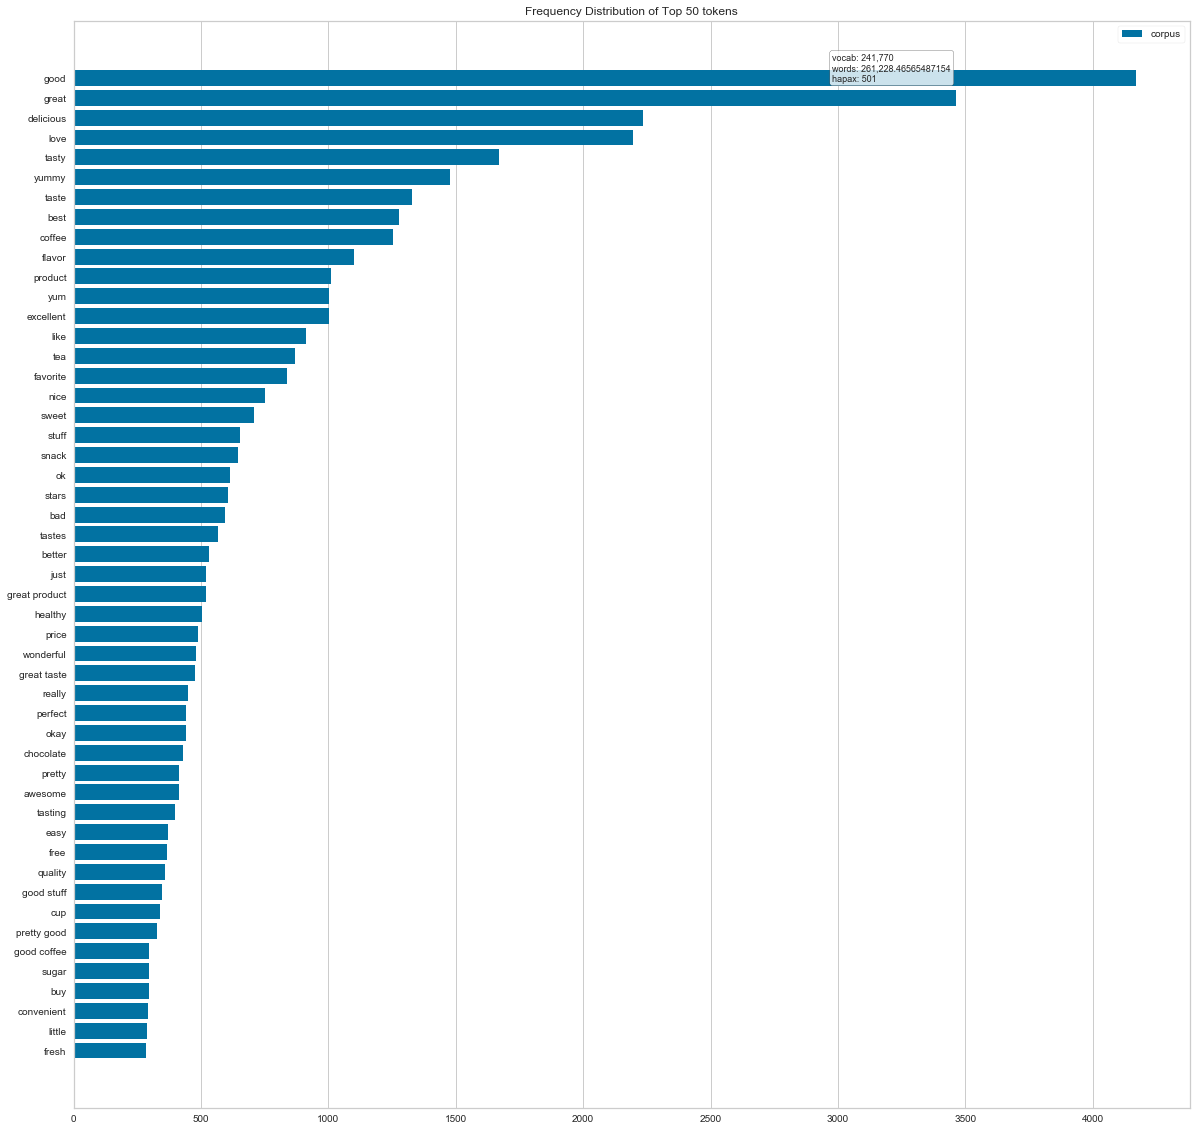

In [17]:
import sklearn.feature_extraction
from yellowbrick.text import FreqDistVisualizer
#a graph of the top 50 most used tokens
features   = countVector.get_feature_names()
visualizer = FreqDistVisualizer(features=features)
fig = plt.figure(1, figsize=(20,20))
visualizer.fit(Xtrain_tfidf)
visualizer.poof()

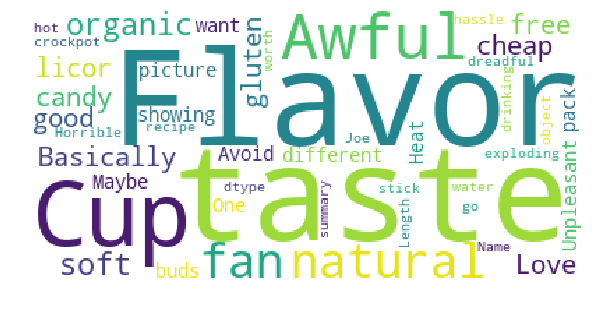

In [20]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

# A word cloud of the summary of badly rated (1) products 
bad=df[df.overall == 1]["summary"]
wc=WordCloud(stopwords=stopwords,background_color="white",random_state=2685).generate(str(bad))
fig = plt.figure(1, figsize=(10,10))
plt.imshow(wc)
plt.axis("off")
plt.show()

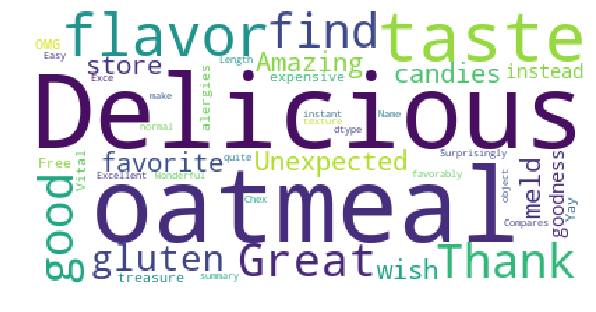

In [21]:
# A word cloud of the summary of highly rated (5) products 
good=df[df.overall == 5]["summary"]
wc=WordCloud(stopwords=stopwords,background_color="white").generate(str(good))
fig = plt.figure(1, figsize=(10,10))
plt.imshow(wc)
plt.axis("off")
plt.show()

### Multinomial Naïve Bayes

Text(0.5, 352.48, 'Predicted label')

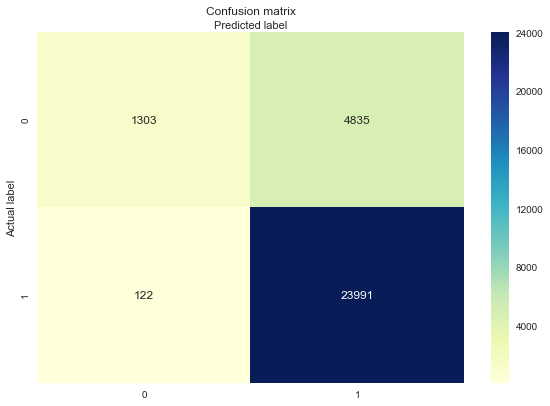

In [22]:
model = MultinomialNB().fit(Xtrain_tfidf, ytrain)
prediction['Multinomial'] = model.predict(Xtest_tfidf)

### Confusion Matrix

cnf_matrix = metrics.confusion_matrix(ytest, prediction['Multinomial'])
fig, ax = plt.subplots()
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

### Logistic regression

Text(0.5, 352.48, 'Predicted label')

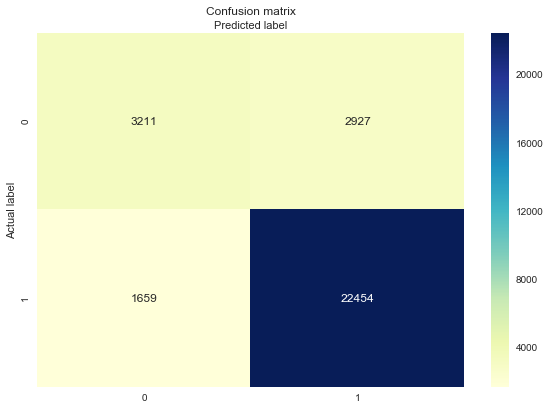

In [24]:
logreg = LogisticRegression(C=1e5)
logreg_result = logreg.fit(Xtrain_tfidf, ytrain)
prediction['Logistic'] = logreg.predict(Xtest_tfidf)

# Confusion Matrix

cnf_matrix = metrics.confusion_matrix(ytest, prediction['Logistic'])
fig, ax = plt.subplots()
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

### AUC-ROC Curve

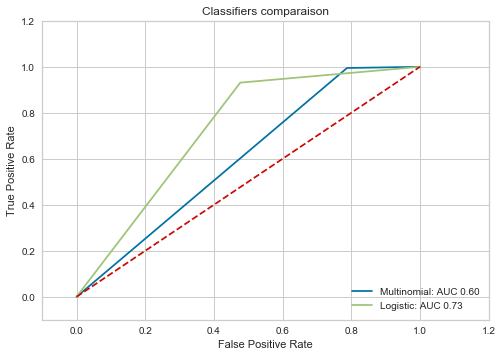

In [26]:
def formatt(x):
    if x == 0:
        return 0
    return 1
vfunc = np.vectorize(formatt)

cmp = 0
colors = ['b', 'g', 'y', 'm', 'k']
for model, predicted in prediction.items():
    false_positive_rate, true_positive_rate, thresholds = roc_curve(ytest.map(formatt), vfunc(predicted))
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, colors[cmp], label='%s: AUC %0.2f'% (model,roc_auc))
    cmp += 1

plt.title('Classifiers comparaison')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Accuracy Score Logistic

In [27]:
accuracy_score(ytest, prediction['Logistic'])

0.8484017057287362

### Accuracy Score Multinomial

In [28]:
accuracy_score(ytest, prediction['Multinomial'])

0.8361376483422036

As seen from the AUC-ROC curve and from the accuracy scores, Logistic Model perform better and will be used as the model below

In [29]:
#a table of features used in logistic models and their coefficients
features = countVector.get_feature_names()
feature_coefs = pd.DataFrame(
    data = list(zip(features, logreg_result.coef_[0])),
    columns = ['feature', 'coefficient'])
feature_coefs.sort_values(by='coefficient')

,feature,coefficient
237984,worst,-18.633714
10283,awful,-18.579338
239881,yuck,-18.073156
111439,horrible,-17.936900
138966,mediocre,-16.657089
165809,poor,-15.028368
133841,lovely perfect,-14.770490
139290,meh,-14.401121
218886,terrible,-13.691252
129774,ll stick,-13.680077


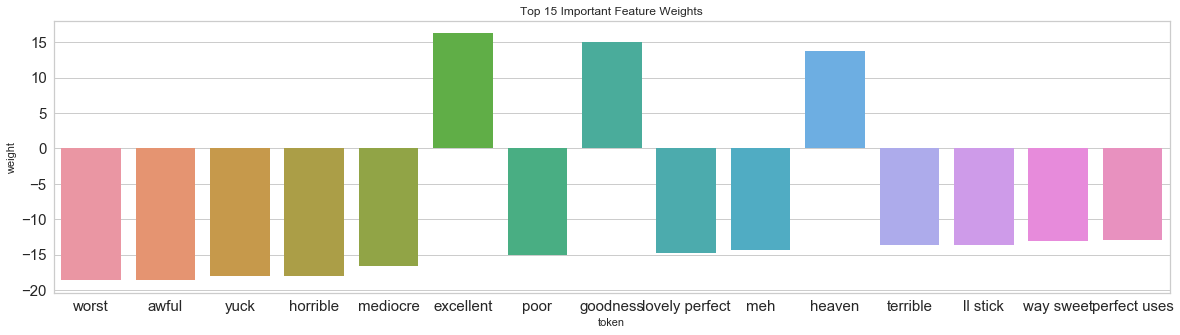

In [30]:
#Top 15 most valuable features 
features = countVector.get_feature_names()
logregcoeff = dict(zip(features,  logreg_result.coef_[0]))
feature_imp = pd.DataFrame.from_dict(logregcoeff, orient='index').reset_index()
feature_imp.columns=('token','weight')
feature_imp = feature_imp.sort_values(by='weight', ascending=False)
feature_imp['abs']=abs(feature_imp['weight'])
top15=feature_imp.nlargest(15,'abs')
sns.barplot(x='token', y='weight', data=top15)            
plt.title("Top 15 Important Feature Weights")
fig=plt.gcf()
fig.set_size_inches(20,5)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.show()

The following function takes any fake review and uses the logistic model we have made above to predict whether it will get a score 1 i.e. rating >3 or a score 0 i.e .rating < 0 and the probabilities of having either score

In [31]:
from sklearn.multioutput import MultiOutputClassifier
def testSentiments(model, testData):
    testCounts = countVector.transform([testData])
    testTfidf = tfidf.transform(testCounts)
    result = model.predict(testTfidf)[0]
    probability = model.predict_proba(testTfidf)[0]
    print("Estimated score is %s: negative prob %f, positive prob %f" % (result, probability[0], probability[1]))

testSentiments(logreg, "Stale bread - will never buy again!!!")
testSentiments(logreg, "Satisfied with the product, it's a steal for the price!")
testSentiments(logreg, "Never had a better experience. Will recommend this jam to all my friends")

Estimated score is 0: negative prob 0.982161, positive prob 0.017839
Estimated score is 1: negative prob 0.038572, positive prob 0.961428
Estimated score is 1: negative prob 0.099254, positive prob 0.900746


Sentiment Analysis of reviews data is a key feature used to predict user behavior. TFIDF is a widely used technique 
for such purposes. It uses stemming, stop words, and size cut offs to give scores to features. Mathematically, the importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus. We have used the following models for this sentiment analysis:
Logistic Regression: It takes a weighted combination of the input features, and passes it through a sigmoid function, which smoothly maps any real number to a number between 0 and 1. The function transforms a real number input, x, into a number between 0 and 1. A logistic classifier would predict the positive class if the sigmoid output is greater than 0.5, and the negative class otherwise.
Multinomial Naive Bayes: It calculates likelihood as count of an word/token (random variable) .With a multinomial event model, samples (feature vectors) represent the frequencies with which certain events have been generated by a multinomial. It works well for data which can easily be turned into counts, such as word counts in text.

# <p style="text-align:center"><span style="color:maroon">Content-Based Filtering of Amazon Groceries using NLP</span></p>
---

### Content-Based Filtering

Content based filtering is another popular approach used in developing recommendations. In content-based filtering, recommendations are derived from the characteristics of the content being pursued. In the case of our Amazon grocery item analyis, our content based analysis is based on the descriptions of the products. Given the limitations of our dataset this seemed to be the most rational approach.

---

In [ ]:
# Import the main libraries to use
import numpy as np
import pandas as pd
import os
import warnings
warnings.simplefilter("ignore")

# Import libraries specific to this analysis
import nltk
from rake_nltk import Rake
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

In [46]:
# path = os.getcwd()
path = "C:/Users/Tamer's ThinkPad/OneDrive - The University of Chicago/MSCA 31008 Data Mining/Project/Data/"

Below, we import our original dataset for to extract the text data.

In [47]:
reviews = pd.read_csv(path + 'reviews_merged.csv')  # adjust to your file path
reviews.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,salesRank,imUrl,categories,title,description,price,related,brand
0,A1VEELTKS8NLZB,616719923X,Amazon Customer,"[0, 0]",Just another flavor of Kit Kat but the taste i...,4.0,Good Taste,1370044800,"06 1, 2013",{'Grocery & Gourmet Food': 37305},http://ecx.images-amazon.com/images/I/51LdEao6...,[['Grocery & Gourmet Food']],Japanese Kit Kat Maccha Green Tea Flavor (5 Ba...,Green Tea Flavor Kit Kat have quickly become t...,NaN,"{'also_bought': ['B00FD63L5W', 'B0047YG5UY', '...",NaN
1,A14R9XMZVJ6INB,616719923X,amf0001,"[0, 1]",I bought this on impulse and it comes from Jap...,3.0,"3.5 stars, sadly not as wonderful as I had hoped",1400457600,"05 19, 2014",{'Grocery & Gourmet Food': 37305},http://ecx.images-amazon.com/images/I/51LdEao6...,[['Grocery & Gourmet Food']],Japanese Kit Kat Maccha Green Tea Flavor (5 Ba...,Green Tea Flavor Kit Kat have quickly become t...,NaN,"{'also_bought': ['B00FD63L5W', 'B0047YG5UY', '...",NaN
2,A27IQHDZFQFNGG,616719923X,Caitlin,"[3, 4]",Really good. Great gift for any fan of green t...,4.0,Yum!,1381190400,"10 8, 2013",{'Grocery & Gourmet Food': 37305},http://ecx.images-amazon.com/images/I/51LdEao6...,[['Grocery & Gourmet Food']],Japanese Kit Kat Maccha Green Tea Flavor (5 Ba...,Green Tea Flavor Kit Kat have quickly become t...,NaN,"{'also_bought': ['B00FD63L5W', 'B0047YG5UY', '...",NaN
3,A31QY5TASILE89,616719923X,DebraDownSth,"[0, 0]","I had never had it before, was curious to see ...",5.0,Unexpected flavor meld,1369008000,"05 20, 2013",{'Grocery & Gourmet Food': 37305},http://ecx.images-amazon.com/images/I/51LdEao6...,[['Grocery & Gourmet Food']],Japanese Kit Kat Maccha Green Tea Flavor (5 Ba...,Green Tea Flavor Kit Kat have quickly become t...,NaN,"{'also_bought': ['B00FD63L5W', 'B0047YG5UY', '...",NaN
4,A2LWK003FFMCI5,616719923X,Diana X.,"[1, 2]",I've been looking forward to trying these afte...,4.0,"Not a very strong tea flavor, but still yummy ...",1369526400,"05 26, 2013",{'Grocery & Gourmet Food': 37305},http://ecx.images-amazon.com/images/I/51LdEao6...,[['Grocery & Gourmet Food']],Japanese Kit Kat Maccha Green Tea Flavor (5 Ba...,Green Tea Flavor Kit Kat have quickly become t...,NaN,"{'also_bought': ['B00FD63L5W', 'B0047YG5UY', '...",NaN


---

### RAKE and NLP Text Extraction (NLTK Library)

After trying out TF-IDF and RAKE in different scenarios, it became obvious (from a heuristics standpoint) that RAKE provided more meaningful results, especially when it comes to item descriptions. The advantage of RAKE is that it can extract words and weights from a single document independent of a complete corpus. This is particularly valuable when exploring a large corpus of unrelated documents such as our grocery data. In most cases, the extractions were quite informative.

---

Make a copy to use for the model.

In [66]:
df = reviews[['title', 'description']].copy(deep=True)

In [67]:
df.head()

,title,description
0,Japanese Kit Kat Maccha Green Tea Flavor (5 Ba...,Green Tea Flavor Kit Kat have quickly become t...
1,Japanese Kit Kat Maccha Green Tea Flavor (5 Ba...,Green Tea Flavor Kit Kat have quickly become t...
2,Japanese Kit Kat Maccha Green Tea Flavor (5 Ba...,Green Tea Flavor Kit Kat have quickly become t...
3,Japanese Kit Kat Maccha Green Tea Flavor (5 Ba...,Green Tea Flavor Kit Kat have quickly become t...
4,Japanese Kit Kat Maccha Green Tea Flavor (5 Ba...,Green Tea Flavor Kit Kat have quickly become t...


**Handle the null entries.**

In [68]:
nulls = df.loc[df['description'].isna(), 'description']
for idx in nulls.index:
    df.at[idx, 'description'] = ''

In [69]:
df.isna().any()

title           True
description    False
dtype: bool

In [70]:
nulls = df.loc[df['title'].isna()].index
df = df.drop(index=nulls)

After removing the duplicate products, our data becomes much more manageable...

In [71]:
df = df.drop_duplicates(); df.shape

(8696, 2)

**Implementing RAKE**

When inmplementing RAKE, it helps to think about how we will use it. There are different ways of extracing terms from a document, either as phrases weighted by overall importance or single words weighted by importance within phrases within documents. We finally settled on the former as it not only made more intuitive sense but also seemed to increase the weight of important words when applying `CountVectorizer` later on. This is because CountVectorizer has to break words up into tokens, so as it does, it will increase the count of a word in a *specific* document and hence its overall score.

In [72]:
# Create a new column in the df for the extracted key words
df['Key_words'] = ""

# Instantiate Rake function with maximum limit of phrase sizes
r = Rake(max_length=4)  

for index, row in df.iterrows():
    desc = row['description']
    
    r.extract_keywords_from_text(desc)  # extract key words or phrases
    
    top_phrases = r.get_ranked_phrases_with_scores()  # get key phrase scores; returns list of tuples
    avg_score_phrases = np.mean(list(dict(top_phrases).keys()))  # get the average score of phrases
    
#     top_words = r.get_word_degrees()  # get key words; returns a dictionary
#     avg_score_words = np.mean(list(top_words.values()))  # get the average score of words
    
    # Select words or phrases with above average scores 
    top_keys = []
    
    for phrase in (top_phrases):  # Iterates over list of (score, phrase) tuples
        if phrase[0] > avg_score_phrases:  # score is first item in tuple
            top_keys.append(phrase[1])  # phrase is second item in tuple
    
#     for word, score in list(top_words.items()):
#         if score > avg_score_words:
#             top_keys.append(word)
    
    row['Key_words'] = top_keys  # add extracted keywords to the new column

# drop description column
df.drop(columns = ['description'], inplace = True)

In [73]:
df['Key_words'].sample(5, random_state=0)

31450    [gmo liquid protein concentrate, naturally occ...
3102                   [mcilhenny tabasco chipotle pepper]
63820                                                   []
76307                                     [linden extract]
23362                                                   []
Name: Key_words, dtype: object

Transform the *key words* into a string of text (a "bag of words") that can be transformed by `CountVectorizer` to develop the count matrix.

In [74]:
df['bag_of_words'] = ''
for index, row in df.iterrows():
    words = ''
    words = words + ' '.join(row['Key_words'])+ ' '
    row['bag_of_words'] = words
    
df.drop(columns = 'Key_words', inplace = True)

The `title` column in the dataframe corresponds to the item. We can set that column as our index since these are the items we want to recommend.

In [75]:
df.set_index('title', inplace=True)

In [76]:
# Instantiate count matrix
count = CountVectorizer()
count_matrix = count.fit_transform(df['bag_of_words'])

# Create a series of the items so they can be ordered numerically and referenced by the recommender
items = pd.Series(df.index)
items[:5]

0    Japanese Kit Kat Maccha Green Tea Flavor (5 Ba...
1          Mae Ploy Thai Green Curry Paste - 14 oz jar
2                    Ateco Food Coloring Kit, 6 colors
3    PowerBar Harvest Energy Bars, Double Chocolate...
4    Traditional Medicinals Breathe Easy, 16-Count ...
Name: title, dtype: object

Calculate cosine similarity for the count matrix.

In [77]:
# Generate the cosine similarity matrix
cosine_sim = cosine_similarity(count_matrix, count_matrix)
# cosine_sim

**Finally, we can build our recommendation function:**

In [78]:
# Returns the top 5 recommendations for a given item based on similarity
def recommendations(title, cosine_sim = cosine_sim):
    
    recommendations = []
        
    idx = items[items == title].index[0]

    score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)

    top_5_idx = list(score_series.iloc[1:6].index)
    
    # populating the list with the titles of the best 10 matching movies
    for i in top_5_idx:
        recommendations.append(list(df.index)[i])
        
    return recommendations

## Let's try it out!

In [99]:
# Suggest a random item:
item = np.random.choice(df.index); item

'Dried Mediterranean Apricots 4 Lbs (in 4 - 16 oz. Reclosable Bags)'

In [103]:
recommendations('Mae Ploy Thai Green Curry Paste - 14 oz jar')

['Mae Ploy Thai Red Curry Paste - 14 ounce per jar',
 'Mae Ploy Thai Panang Curry Paste - 14 oz jar',
 'Mae Ploy Thai Matsaman (Massaman) Curry Paste - 14 oz jar',
 'Mae Ploy Thai Yellow Curry Paste - 14 oz jar',
 'Hormel&reg; Black Label Fully Cooked Bacon - 72 ct']

# Simple Popularity, Item-Item Collaborative Filtering  and Matrix Factorization models using Turicreate

TuriCreate was developed by Apple and uses it's own type of dataframe called SFrame.  The package has it's own visualization capabilities which are briefly tried below.

The code below shows methodology testing a simple popularity model and two more advanced recommendation methods using cosine similarity and matrix factorization within TuriCreate.

In the simiple popularity model, we simply find the most popular items (those most often rated 5.0) and recommend these items to users.  I think this method may be useful in a true cold start scenario, but not useful in more in depth situations.

More advanced methods are shown by finding the cosine similarity of items and recommending to a user a 'similar' item to an item which they've previously purchased.  This method only produced a RMSE of 4.301, which can be improved. 

The final method we tried was a matrix factorization approach in which both similar items and similar users are found based on rating histories. This model was able to produce stronger recommendations and resulted in a 1.27 RMSE

In [ ]:
df = merged.copy()
df= df.drop(columns = [ 'reviewerName','helpful', 'unixReviewTime', 'reviewTime'])
df = df.drop(columns = ['reviewText','summary'])

tu_data = turicreate.SFrame(df)

tu_data['overall'].show()

1. Create a simple popularity model: all users have the same recommendation based on the most popular choices

In [ ]:
#create instance
popularity_model = turicreate.popularity_recommender.create(tu_data, user_id = 'reviewerID', item_id = 'asin', target = 'overall')

#find top 5 products for first 5 users
#in the event that user already rated that product, it's not proposed again

popularity_recomm = popularity_model.recommend(users = [1,2,3,4,5], k = 5)
popularity_recomm.print_rows(num_rows = 25)

meta.loc[meta['asin']== 'B0000CNU15']

meta.loc[meta['asin']== 'B0000CFLIL']

meta.loc[meta['asin']== 'B0000CFLCT']

meta.loc[meta['asin']== 'B0000CDBQN']

meta.loc[meta['asin']== 'B00005C2M2']





#verifying if these product are indeed the top 5 highly rated products. 
#looks like there is an issue because there are many products with mean rating of 5.0
# a more sophisticated model is likely needed

df.groupby(by = 'asin')['overall'].mean().sort_values(ascending = False).head(20)

#create a train test split
training_data, validation_data = turicreate.recommender.util.random_split_by_user(tu_data, 'reviewerID', 'asin',item_test_proportion=0.2)


#Create a model based on item-item similarity

#create an instance
item_sim_model = turicreate.item_similarity_recommender.create(training_data, user_id = 'reviewerID', item_id = 'asin', target = 'overall', similarity_type = 'cosine')

items_similarity = item_sim_model.get_similar_items()

#before evealuating the model, empirically test what the model thinks are similar products to ASIN '616719923X'
(items_similarity[(items_similarity['asin'] == '616719923X' )]).sort('rank', ascending = True).print_rows()




meta.loc[meta['asin']== '616719923X']

meta.loc[meta['asin']== 'B004MFNGEQ']

meta.loc[meta['asin']== 'B0007LXU86']

meta.loc[meta['asin']== 'B00374ZKQ0']

meta.loc[meta['asin']== 'B0052589L0']

meta.loc[meta['asin']== 'B005VBDBT0']

meta.loc[meta['asin']== 'B0013TJB7K']

These products all belong to a desert category so they look similar to me. Furthermore, the item with a .26 score in similarity to the given item contains the word tea, which the given item also has.  This tells me that the model has conceptionally grouped similar items together

item_sim_model.evaluate(validation_data)

RMSE = 4.301 (Very poor)

In [ ]:
#This is the model's recommended products.  I don't like these recommendations because they are the same products
item_sim_recomm = item_sim_model.recommend(users = [1,2,3,4,5], k = 5)
item_sim_recomm.print_rows(num_rows = 25)

df.head()

#Trying a matrix factorization approach takes into account users AND items.  It uses the latent features created to minimize the RMSE, and uses Stochastic Gradient Descent while optimizing thelearning rate

model = turicreate.recommender.ranking_factorization_recommender.create(training_data, user_id = 'reviewerID', item_id = 'asin', target = 'overall')

results = model.recommend(k=3)

results.sort(['reviewerID', 'rank'], ascending=True).print_rows(20)

model.evaluate(validation_data)

this produced a much better RMSE

meta.loc[meta['asin']== 'B000GAT6NG']

meta.loc[meta['asin']== 'B000ENUC3S']

meta.loc[meta['asin']== 'B001CGTN1I']

df.loc[df['reviewerID']=='A022899328A0QROR32DCT']

meta.loc[meta['asin']== 'B003V8QGAG']

meta.loc[meta['asin']== 'B003VIJI38']

meta.loc[meta['asin']== 'B000EVE3Y4']

meta.loc[meta['asin']=='B007OSBFY6']

meta.loc[meta['asin']=='B003TO9RSU']

# Matrix Factorization, Stochastic Gradient Descent & Predicting User Ratings 

This process uses Matrix Factorization and SGD to predict a user's rating on a product.  The user would then be recommended their highest predicted rated products.  

The process begins by creating a pivot table with all products representing the columns, users representing the rows and any given ratings representing the values.  As there will likely be a lot of products each user did not rate, these values are represented by NaN.  
Because we cannot use NaN in calcuations, and also because the users were asked to rate products on a 1-5 scale, we can transform any NaN value into a 0.

Now that data has been transformed properly, Matrix Factorization and Stochastic Gradient Descent will be used to create predicted ratings for each product, for each user.  

Matrix Factorization on a high level is producing two matrices whose product is the original matrix given. The two matrices represent generated item and user features.  The features are inferred from their related rating patterns.  High correspondence between item and user factors lead to a recommendation.

Matrix factorization models map both users and items to a joint latent factor space of dimensionality f, such that user-item interactions are modeled as inner products in that space.  The result is each item will have a vector Q and each user will have a vector P.  For each product Q, its' elements show the extent to which the items possess those factors.  For each user P, it's elements show the extent to which the user is interested in items high on the corresponding factors.  The resulting dot product Q * P captures the interaction between user and product and approximates the user's rating on that product.

Within the Matrix Factorization process, Stochastic Gradient Descent is used to avoid imputation and overfitting.  This approach helps to model directly the observed ratings only, and generalizes these ratings in such a way that predicts future ratings.  A minimum squared error is used to find the expected rating and to avoid overfitting, a constant is applied to control the extent of regularization.  SGD uses a magnitude in the opposite direction of the gradient to normalize the given rating.

A challenge of our model is that we were given 5core data which guarentees each user gave at least 5 ratings, and each product had at least 5 ratings.  So in some instances, we will be making inferences based on only 5 inputs by the user(s).

Althought not included in this model, a strength of matrix factorization is it allows for incorporation of additional information including implicit feedback, which can be defined as inferred user preferences based on observing user behavior including: browsing history, search patterns, mouse movements, and purchase history.  Implicit feedback usually represents the presence or absence of an event.

#using the ratings data, create a new table that has all products as the columns(8713), all users as the rowsm and any product that the rated appearing under the respective product.
#if that user did not provide a rating for a product, it will appear as NA

In [ ]:
rating = pd.pivot_table(df, values = 'overall', index = ['reviewerID'], columns = ['asin'])

rating.sort_index(axis = 1, inplace = True)

rating.head()

meta.loc[meta['asin']=='B00004S1C5']

#because the lowest rating is 1 (products were rated on a scale of 1-5), i can fill all NaN values with 0 to represent no rating
ratings = rating.fillna(0)

#this gives a DF that can have calculations performed on it
ratings.head()

#creating the Matrix Factorization process

class MF():

    # Initializing the user-product rating matrix, no. of latent features, alpha and beta.
    def __init__(self, R, K, alpha, beta, iterations):
        self.R = R
        self.num_users, self.num_items = R.shape
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations

    # Initializing user-feature and product-feature matrix 
    def train(self):
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))

        # Initializing the bias terms
        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)
        self.b = np.mean(self.R[np.where(self.R != 0)])

        # List of training samples
        self.samples = [
        (i, j, self.R[i, j])
        for i in range(self.num_users)
        for j in range(self.num_items)
        if self.R[i, j] > 0
        ]

        # Stochastic gradient descent for given number of iterations
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            mse = self.mse()
            training_process.append((i, mse))
            if (i+1) % 20 == 0:
                print("Iteration: %d ; error = %.4f" % (i+1, mse))

        return training_process

    # Computing total mean squared error
    def mse(self):
        xs, ys = self.R.nonzero()
        predicted = self.full_matrix()
        error = 0
        for x, y in zip(xs, ys):
            error += pow(self.R[x, y] - predicted[x, y], 2)
        return np.sqrt(error)

    # Stochastic gradient descent to get optimized P and Q matrix
    def sgd(self):
        for i, j, r in self.samples:
            prediction = self.get_rating(i, j)
            e = (r - prediction)

            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            self.b_i[j] += self.alpha * (e - self.beta * self.b_i[j])

            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i,:])
            self.Q[j, :] += self.alpha * (e * self.P[i, :] - self.beta * self.Q[j,:])

    # Ratings for user i and product j
    def get_rating(self, i, j):
        prediction = self.b + self.b_u[i] + self.b_i[j] + self.P[i, :].dot(self.Q[j, :].T)
        return prediction

    # Full user-product rating matrix
    def full_matrix(self):
        return mf.b + mf.b_u[:,np.newaxis] + mf.b_i[np.newaxis:,] + mf.P.dot(mf.Q.T)

R = np.array(ratings)

mf = MF(R, K = 20, alpha=0.001, beta = 0.01, iterations = 100)
training_process = mf.train()
print()
print("P x Q:")
print(mf.full_matrix())
print()

# LightFM 

LightFM is a matrix factorization method of producing recommendations.  In creating the two new matrixes from the original interaction matrix, a WARP loss function was used in this case.  The resulting efforts were strong item recommendations for a user, and user recommendations to an item.

A note on warp loss function- WARP stands for Weighted Approximate-Rank Pairwise loss and it's advantage among other loss functions is that it optimizes for the loss function's value relative to the other loss functions values.  Loss functions are designed to weight predictions on a scale, going further than a simple 0 or 1 for purchase/no purchase. WARP is designed to randomly sample output labels of the model until it finds a pair which it knows are wrongly labelled, and then applies an update only to those two incorrectly labelled examples.  The result is a model that learns to rank items it knows are positive above others and account for relative ranked items in terms of user preference.

from scipy import sparse

from lightfm import LightFM

In [ ]:
merged = pd.read_csv('/Users/marcushimelhoch/Downloads/reviews_merged.csv', sep = ',')

merged.head()


def create_user_dict(ratings):
    
    user_id = list(ratings.index)
    user_dict = {}
    counter = 0 
    for i in user_id:
        user_dict[i] = counter
        counter += 1
    return user_dict
    
def create_item_dict(df,id_col,name_col):
 
    item_dict ={}
    for i in range(df.shape[0]):
        item_dict[(df.loc[i,id_col])] = df.loc[i,name_col]
    return item_dict

def runMF(ratings, n_components=30, loss='warp', k=15, epoch=30,n_jobs = 4):
  
    x = sparse.csr_matrix(ratings.values)
    model = LightFM(no_components= n_components, loss=loss,k=k)
    model.fit(x,epochs=epoch,num_threads = n_jobs)
    return model

def sample_recommendation_user(model, ratings, user_id, user_dict, 
                               item_dict,threshold = 0,nrec_items = 10, show = True):
   
    n_users, n_items = ratings.shape
    user_x = user_dict[user_id]
    scores = pd.Series(model.predict(user_x,np.arange(n_items)))
    scores.index = ratings.columns
    scores = list(pd.Series(scores.sort_values(ascending=False).index))
    
    known_items = list(pd.Series(ratings.loc[user_id,:] \
                                 [ratings.loc[user_id,:] > threshold].index) \
								 .sort_values(ascending=False))
    
    scores = [x for x in scores if x not in known_items]
    return_score_list = scores[0:nrec_items]
    known_items = list(pd.Series(known_items).apply(lambda x: item_dict[x]))
    scores = list(pd.Series(return_score_list).apply(lambda x: item_dict[x]))
    if show == True:
        print("Known Likes:")
        counter = 1
        for i in known_items:
            print(str(counter) + '- ' + i)
            counter+=1

        print("\n Recommended Items:")
        counter = 1
        for i in scores:
            print(str(counter) + '- ' + i)
            counter+=1
    return return_score_list
    

def sample_recommendation_item(model,ratings,item_id,user_dict,item_dict,number_of_user):
   
    n_users, n_items = ratings.shape
    x = np.array(ratings.columns)
    scores = pd.Series(model.predict(np.arange(n_users), np.repeat(x.searchsorted(item_id),n_users)))
    user_list = list(ratings.index[scores.sort_values(ascending=False).head(number_of_user).index])
    return user_list 




# use ratings interaction matrix already created in matrix factorization step
mf_model = runMF(ratings = ratings,
                 n_components = 30,
                 loss = 'warp',
                 epoch = 30,
                 n_jobs = 4)

user_dict = create_user_dict(ratings = ratings)

item_dict = create_item_dict(df = merged,
                            id_col = 'asin',
                            name_col = 'title')

Recommending Items to a User

In [ ]:
rec_list = sample_recommendation_user(model = mf_model,
                                     ratings = ratings,
                                     user_id = 'A00177463W0XWB16A9O05',
                                     user_dict = user_dict,
                                     item_dict = item_dict,
                                     threshold = 4,
                                     nrec_items = 10,
                                     show = True)

print(rec_list)

Recommending Users to an Item

In [ ]:
sample_recommendation_item(model = mf_model,
                          ratings = ratings,
                          item_id = 'B007OSBFY6',
                          user_dict = user_dict,
                          item_dict = item_dict,
                          number_of_user = 10)























# Import Meta Data for Content-Based Methods

import pandas as pd
meta = pd.read_csv('/Users/marcushimelhoch/Downloads/meta_filtered.csv')

meta.head()

meta['categories'] = meta['categories'].map(lambda x: x.lower().split('&'))

meta.head()

meta.isnull().sum()



meta = meta.dropna(subset = ['description'])

meta.head()

meta.isnull().sum()

type(meta.title)

# TFIDF , Truncated SVD and KMeans

The purpose of this method is to cluster similar item descriptions together and recommend items to users that are similar to what they've purchased previously.
TfIDF assigns a value to each word based on the frequency of its appearance.  It then accounts for unimportant words by assigning a negative weight to words such as 'the', 'it', (etc).  Finally, it creates a matrix with the columns representing all words appearing in all of the selected text, and each observation representing the rows.
This will be a very sparse matrix because not all words will appear in all item descriptions.  To work more effectively with a sparse matrix, TruncatedSVD reduces the dimensions by only remembering the non-zero entries.  We use this method because scikit-learn PCA doesn't support the alternate method, scipy.sparse.csr_matrix.  Dimension reduction is helpful because it retains high variances features, discards low variance features and assumes high variance features are important- resulting in a smaller matrix with just as much information.
Now that each observation contains a vector of values corresponding to the frequency of each of it's words' appearance in all item descriptions, we can now cluster similar vectors together using KMeans.  KMeans is able to cluster similar observations together using distance metrics for each column.  It is an efficient and simple model, however it requires the number of clusters to be stated, which could be a weak point of this method.

The conclusion of this process is: if a user bought a Kit Kat bar, we would look at what cluster the Kit Kat bar belongs to.  If it belongs to cluster #1, we would recommend other items in cluster #1 to that user.

In [ ]:
meta.head()

#take the text out of the description column
text = meta.description.values

#take the text out of the title column
titles = meta.title.values

#
from sklearn.feature_extraction.text import TfidfVectorizer

#create an instance
tfidf = TfidfVectorizer()

#apply fit/transform to my text
csr_mat = tfidf.fit_transform(text)

#print the result of .toarray method
print(csr_mat.toarray())

#get just the words
words = tfidf.get_feature_names()

#print the words
print(words)


from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.manifold import TSNE





#from sklearn.cluster import KMeans
#wcss = []

#for i in range(1, 11):
 #   kmeans = KMeans(n_clusters = i, init = 'k-means++',
                #    max_iter = 400, n_init = 10, random_state = 0)
  #  kmeans.fit(csr_mat)
   # wcss.append(kmeans.inertia_)
    
#Plotting the results onto a line graph to observe 'The elbow'
#plt.plot(range(1, 11), wcss)
#plt.title('Elbow Method')
#plt.xlabel('Association')
#plt.ylabel('WCSS') #within cluster sum of squares
#plt.show()



#create an instance with 50 components
svd = TruncatedSVD(n_components = 50)


#create a KMeans instance with 15 clusters.
#Because the elbow method will take too long with this data, using an assumed 15 clusters
kmeans = KMeans(n_clusters = 15)

#create a pipeline for TruncatedSVD and Kmeans 
pipeline = make_pipeline(svd, kmeans)

#fit the pipelien to my matrix generated above
pipeline.fit(csr_mat)

#create the predictions/cluster labels (0,1,2...15)
labels = pipeline.predict(csr_mat)

labels 

In [ ]:
#create a DF with cluster labels and title of item
df = pd.DataFrame({'label': labels, 'item': titles})

#desert items have been clustered in cluster #0, cocunut itmes clustered at cluster #14, etc
df.sort_values('label')

df.head()





# CountVectorizer with Description

This method is similar to TfIDF in that it assesses the frequency of words appearing in the item descriptions.  It differs from TfIDF by it's use of cosine similarity to determine the relatively 'closeness' of items to other items.

The method starts by transforming the item descriptions into a count matrix in which each observation contains the frequency of each word in the related columns.  
Next, it uses cosine similarity to determine the relationships between each observation and it's words.
Finally, a function is created to return the top 10 recommended items based on their related cosine similarities

In [ ]:
#create an instance
count = CountVectorizer()

#fit and transform the "description column"
count_matrix = count.fit_transform(meta['description'])

count_matrix.shape

#use cosine similarity to asses similarities between terms
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim = cosine_similarity(count_matrix, count_matrix)
cosine_sim

#assign item titles to be the indicies
indices = pd.Series(meta['title'])

#define new function recommendation that recomends based on the previously completed cosine similiarity and uses item titles to call the recommendation

def recommendations(title, cosine_sim = cosine_sim):
    #create empty list
    recommended_product = []
    
    #create index using previously created indicies
    idx = indices[indices == title].index[0]
    
    #create a series of cosine similarity scores sorted
    score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)
    
    #find top 10 products according to cosine sim
    top_10_indexes = list(score_series.iloc[1:11].index)
    
    #add these top 10 similar products to list: recommended_product
    for i in top_10_indexes:
        recommended_product.append(list(df.index)[i])
        
    return recommended_product

#find an item title from meta data
meta.title[1]

#what are the recommended prodcuts if a user bought this green curry paste ?
recommendations('Mae Ploy Thai Green Curry Paste - 14 oz jar')

#what is item 722?
meta.iloc[722].title

meta.iloc[723].title

meta.iloc[725].title

meta.iloc[5031].title

# Sources

Amazon Product Data  
Julian McAuley, UCSD  
http://jmcauley.ucsd.edu/data/amazon/  

Matrix Factorization Techniques for Recommender Systems  
https://towardsdatascience.com/paper-summary-matrix-factorization-techniques-for-recommender-systems-82d1a7ace74
  
How Does the Funk Singular Value Decomposition Algorithm work in Recommendation Engines?  
https://medium.com/datadriveninvestor/how-funk-singular-value-decomposition-algorithm-work-in-recommendation-engines-36f2fbf62cac  

Netflix Prize and SVD  
http://buzzard.ups.edu/courses/2014spring/420projects/math420-UPS-spring-2014-gower-netflix-SVD.pdf  

Learning from Incomplete Ratings Using Non-negative Matrix Factorization  
https://archive.siam.org/meetings/sdm06/proceedings/059zhangs2.pdf
  
Non-negative matrix factorization for recommendation systems  
https://medium.com/logicai/non-negative-matrix-factorization-for-recommendation-systems-985ca8d5c16c  

Python Surprise Library  
http://surpriselib.com/